In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [64]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso
import sklearn.gaussian_process.kernels as kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

np.set_printoptions(linewidth=150, edgeitems=5)
result_list = []

コンクリートの強度に影響を与える要因について考える。成分などを予測因子として用いてコンクリートの強度を予測する。
説明変数
CementComponent:- セメントの含有量
BlastFurnaceSlag:- 高炉スラグの配合量
FlyAshComponent:- フライアッシュの配合量
WaterComponent:- 水の配合量
SuperplasticizerComponent:- 減水剤の配合量 
CoarseAggregateComponent:- 粗骨材の配合量
FineAggregateComponent:- 細骨材の配合量
AgeInDays:- 乾燥したまま放置された日数
Strength:- コンクリートの最終強度

In [65]:
df_train = pd.read_csv("data/train.csv", index_col='id')
df_test = pd.read_csv("data/test.csv", index_col='id')
target = 'Strength'

In [6]:
df_train.head(5)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [27]:
df_train.isnull().sum()

id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

各特徴量のヒストグラムを表示
訓練データとテストデータの分布は良くにている
CementComponent, WaterComponent, CoarseAggregateComponent, FineAggregateComponent は全てのサンプルに含まれる（含有量が０出ない）で
BlastFurnaceSlag, FlyAshComponent, SuperplasticizerComponent　が含まれないサンプルも存在するため, バイナリデータ（0 or 1)として扱うことも可能



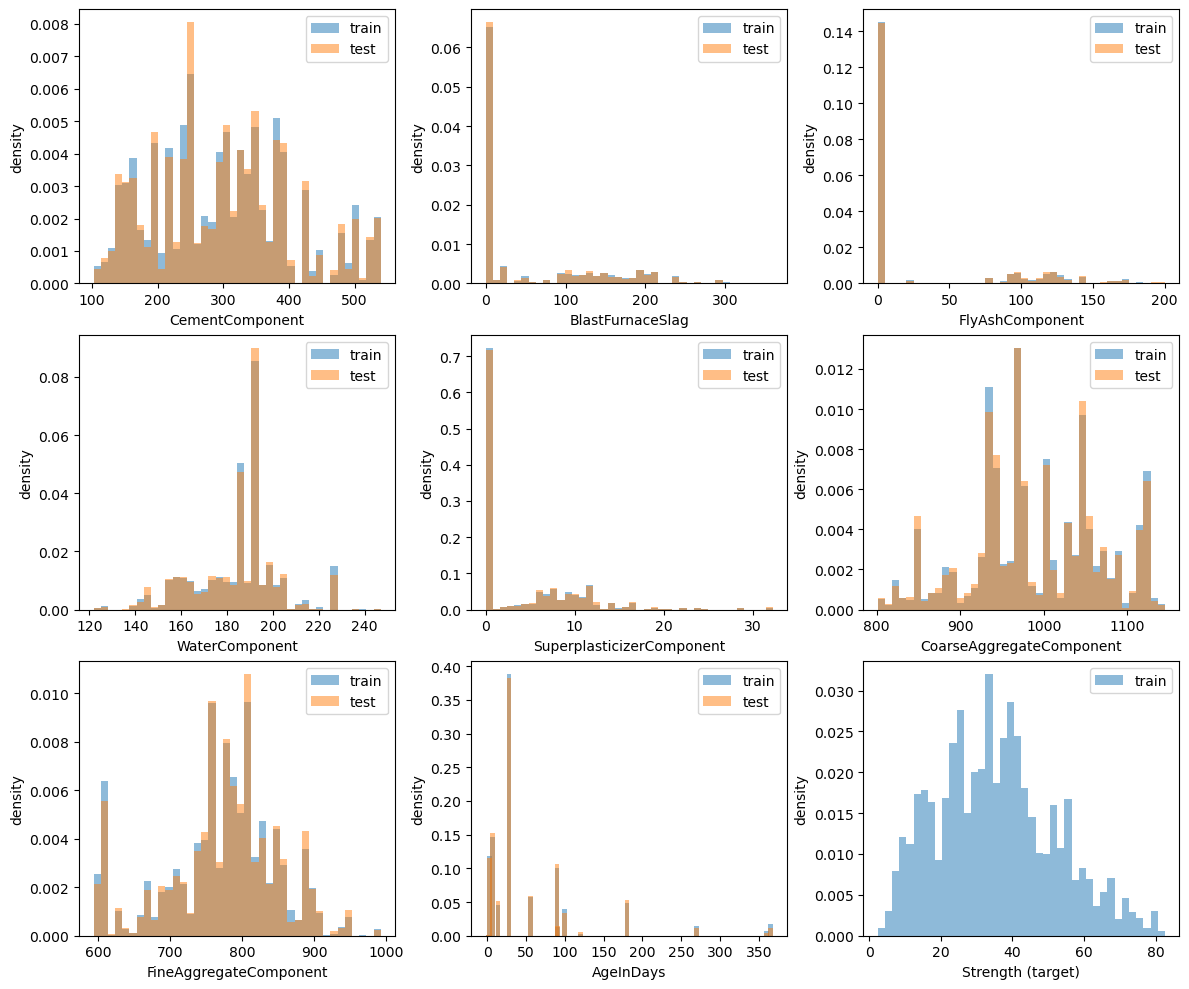

In [7]:
def analyze(train, test, col, ax):
    """Plot a histogram for column col into axes ax"""
    bins = 40
    column = train[col]
    if col in test.columns:
        both = np.hstack([column.values, test[col].values])
    else:
        both = column
    uni = np.unique(column)
    unival = len(uni)
    if unival < bins:
        vc_tr = column.value_counts().sort_index() / len(train)
        if col in test.columns:
            vc_te = test[col].value_counts().sort_index() / len(test)
            ax.bar(vc_tr.index, vc_tr, width=6, label='train', alpha=0.5)
            ax.bar(vc_te.index, vc_te, width=6, label='test', alpha=0.5)
        else:
            ax.bar(vc_tr.index, vc_tr, label='train', alpha=0.5)
        if unival <= 12:
            ax.set_xticks(vc_tr.index)
        else:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
        ax.set_xlabel(col + (' (target)' if col == target else ''))
        ax.set_ylabel('density')
        ax.legend()
    else:
        hist_bins = np.linspace(both.min(), both.max(), bins+1)
        ax.hist(column, bins=hist_bins, density=True, label='train', alpha=0.5)
        if col in test.columns:
            ax.hist(test[col], bins=hist_bins, density=True, label='test', alpha=0.5)
        ax.set_xlabel(col + (' (target)' if col == target else ''))
        ax.set_ylabel('density')
        ax.legend()
    
_, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.ravel()
for col, ax in zip(df_train.columns, axs):
    analyze(df_train, df_test, col, ax)
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [4]:
# バイナリとして扱える特徴量とそうでない特徴量をリストに格納しておく
avail_bin = ["BlastFurnaceSlag", "FlyAshComponent", "SuperplasticizerComponent"]
nonavail_bin = ["CementComponent", "WaterComponent", "CoarseAggregateComponent", "FineAggregateComponent"]

# バイナリとして扱える特徴量を具体的に見てみる
print(df_train[(df_train[avail_bin[0]] == 0) & (df_train[avail_bin[1]] == 0) & (df_train[avail_bin[2]] == 0)].shape)
# 5407のトレインデータの内, avail_binの全てが含まれていないサンプルが2140ある
print(df_train[(df_train[avail_bin[0]] == 0) | (df_train[avail_bin[1]] == 0) | (df_train[avail_bin[2]] == 0)].shape)
# 5407のトレインデータの内, avail_binのいずれかが含まれていないサンプルが4761ある

(2140, 9)
(4761, 9)


In [15]:
# 乾燥時間について見てみる
print('Value counts for AgeInDays')
pd.concat([df_train,df_test], axis=0).AgeInDays.value_counts().sort_index()
# ある一定の期間で乾燥時間を設定していることが分かる.

Value counts for AgeInDays


1         8
3      1053
7      1345
11        1
14      435
28     3474
49        1
56      526
90      922
91      124
100     334
120      36
180     454
270     116
360      52
365     131
Name: AgeInDays, dtype: int64

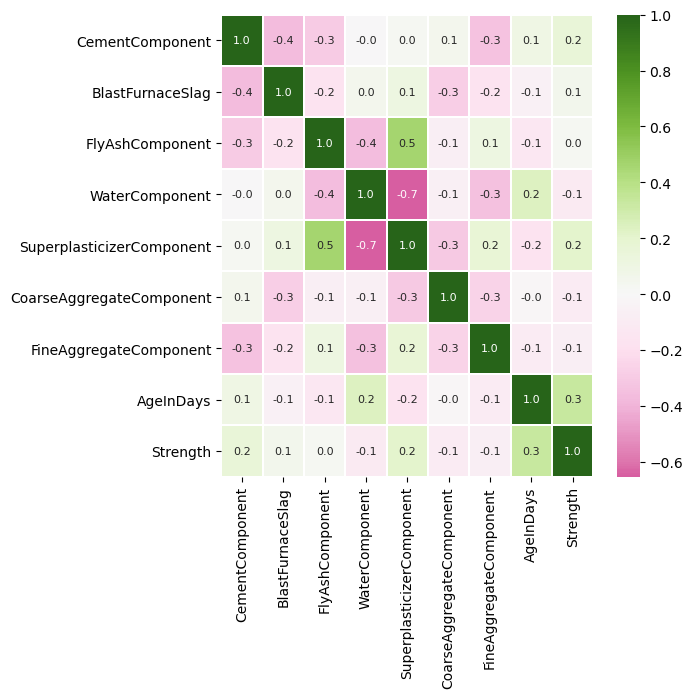

In [5]:
# ヒートマップにより相関を確認
corr = df_train.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, linewidth=0.1, fmt='.1f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='PiYG', center=0)
plt.show()

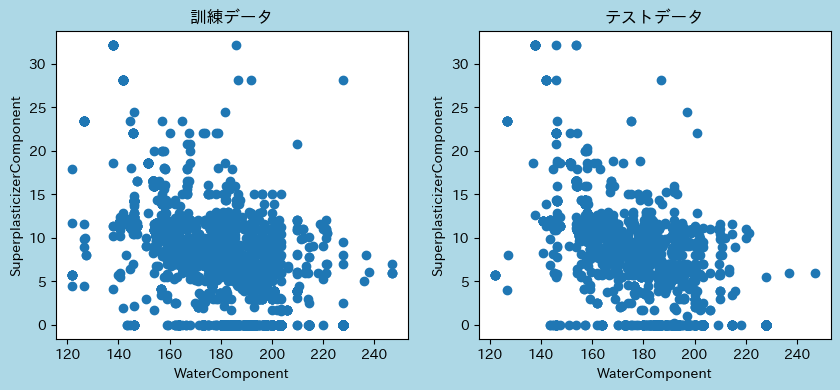

In [32]:
# 相関の高い特徴量について散布図を書いてどのような関係にあるかを確認する
def draw_scatter(x, y, futures, titles):
    #グラフを表示する領域を，figオブェクトとして作成．
    fig = plt.figure(figsize = (10,4), facecolor='lightblue')
    #グラフを描画するsubplot領域を作成。
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.scatter(x[0], y[0])
    ax2.scatter(x[1], y[1])
    ax1.set_xlabel(futures[0])
    ax2.set_xlabel(futures[0])
    ax1.set_ylabel(futures[1])
    ax2.set_ylabel(futures[1])
    ax1.set_title(titles[0])
    ax2.set_title(titles[1])

future_pair = ("WaterComponent", "SuperplasticizerComponent")
x_list = [df_train[future_pair[0]], df_test[future_pair[0]]]
y_list = [df_train[future_pair[1]], df_test[future_pair[1]]]
titles = ["訓練データ", "テストデータ"]
draw_scatter(x_list, y_list, future_pair, titles)


In [75]:
def score_model(model, n, features_used, label=None):
    """Cross-validate a model with feature selection"""
    oof = np.zeros_like(df_train[target])
    score_list = []
    kf = KFold(n, shuffle=True)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(df_train)):
        X_tr = df_train.iloc[idx_tr][features_used]
        X_va = df_train.iloc[idx_va][features_used]
        y_tr = df_train.iloc[idx_tr][target]
        y_va = df_train.iloc[idx_va][target]
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        # print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))
    
    return rmse

original_features = list(df_test.columns)
ave_list = []
for n in range(6, 7):
    ave_list.append(score_model(model=make_pipeline(StandardScaler(), Ridge(70)), n=n, features_used=original_features))
if len(ave_list) == 1:
    print(f"score:{ave_list[0]}")
else:
    x = np.array(range(3, 3+len(ave_list)))
    y = np.array(ave_list)
    plt.plot(x, y)

Average rmse: 14.598
score:14.598001843498153


In [86]:
# 描画関数
def draw_result(aves):
    if len(aves) == 1:
        print(f"score:{aves[0]}")
    else:
        x = np.array(range(3, 3+len(aves)))
        y = np.array(aves)
        plt.plot(x, y)

In [78]:
for df in [df_train, df_test]:
    df['hasBlastFurnaceSlag'] = df.BlastFurnaceSlag != 0
    df['hasFlyAshComponent'] = df.FlyAshComponent != 0
    df['hasSuperplasticizerComponent'] = df.SuperplasticizerComponent != 0

id
0       False
1        True
2        True
3        True
4        True
        ...  
5402     True
5403    False
5404    False
5405     True
5406    False
Name: hasBlastFurnaceSlag, Length: 5407, dtype: bool
Average rmse: 14.530


In [94]:
# リッジ回帰
ave_list = []
model=make_pipeline(StandardScaler(), Ridge(70))
ave_list.append(score_model(model,n=6, features_used=df_test.columns))
draw_result(ave_list)
y_pred = model.predict(df_test[df_test.columns])
pd.Series(y_pred, index=df_test.index, name=target).to_csv(f"data/submission.csv")
y_pred.round(1)

Average rmse: 14.535
score:14.535492334517784


array([37.2, 26.9, 26.9, 39.1, 33.7, ..., 33.5, 28.3, 38.8, 49.5, 29.3])

Average rmse: 12.138
Average rmse: 12.128
Average rmse: 12.169
Average rmse: 12.141
Average rmse: 12.144
Average rmse: 12.110
Average rmse: 12.146
Average rmse: 12.165


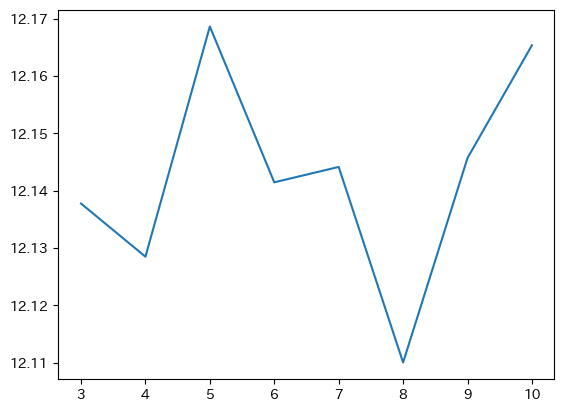

In [89]:
# ランダムフォレスト
ave_list = []
model=RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)

score_model(model,n=6, features_used=df_test.columns)
for n in range(3, 11):
    ave_list.append(score_model(model,n=n, features_used=df_test.columns))
draw_result(ave_list)

In [99]:
# ランダムフォレストで予測
model=RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
score_model(model,n=8, features_used=df_test.columns)
y_pred = model.predict(df_test[df_test.columns])
pd.Series(y_pred, index=df_test.index, name=target).to_csv(f"data/submission.csv")
y_pred.round(1)

Average rmse: 12.142


array([51.6, 19.9, 33.5, 47.1, 33.3, ..., 33.5, 38. , 39. , 27.9, 22.4])

id
0       False
1        True
2        True
3        True
4        True
        ...  
5402     True
5403    False
5404    False
5405     True
5406    False
Name: hasBlastFurnaceSlag, Length: 5407, dtype: bool


In [17]:
y = df_train["Strength"]
y = np.array(y)
y

array([10.38, 23.52, 36.96, ..., 39.3 , 39.61, 63.14])

In [25]:
x = df_train["AgeInDays"]
x = np.array(x)

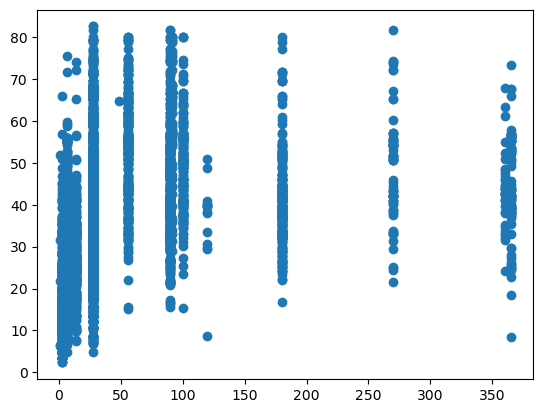

In [26]:
plt.scatter(x, y)